In [30]:
using Flux
using BSON: @load
using Chemfiles
using Plots

struct G2
    eta::Float64
    rcutoff::Float64
    rshift::Float64
end

function build_distance_matrix(frame)
    N = length(frame)
    return [distance(frame, i - 1, j - 1) for i in 1:N, j in 1:N]
end

function distance_cutoff(d, rcutoff=10.0)
    return d > rcutoff ? 0.0 : 0.5 * (cos(π * d / rcutoff) + 1.0)
end

function compute_g2(distances, eta, rcutoff, rshift)
    return sum(exp(-eta * (d - rshift)^2) * distance_cutoff(d, rcutoff) for d in distances if d > 0.0)
end

function build_g2_matrix(distance_matrix, g2_functions)
    N = size(distance_matrix, 1)
    g2_matrix = zeros(Float64, N, length(g2_functions))
    for i in 1:N
        distances = distance_matrix[i, :]
        for (j, g2_func) in enumerate(g2_functions)
            g2_matrix[i, j] = compute_g2(distances, g2_func.eta, g2_func.rcutoff, g2_func.rshift)
        end
    end
    return g2_matrix
end

build_g2_matrix (generic function with 1 method)

In [31]:
g2_list = [
    G2(0.000, 15.0, 0.00),
    G2(0.000, 5.50, 0.00),
    G2(10.456, 15.0, 3.00),
    G2(10.456, 15.0, 3.50),
    G2(10.456, 15.0, 4.00),
    G2(10.456, 15.0, 4.50),
    G2(10.456, 15.0, 5.00),
    G2(10.456, 15.0, 5.50),
    G2(10.456, 15.0, 6.00),
 ]


9-element Vector{G2}:
 G2(0.0, 15.0, 0.0)
 G2(0.0, 5.5, 0.0)
 G2(10.456, 15.0, 3.0)
 G2(10.456, 15.0, 3.5)
 G2(10.456, 15.0, 4.0)
 G2(10.456, 15.0, 4.5)
 G2(10.456, 15.0, 5.0)
 G2(10.456, 15.0, 5.5)
 G2(10.456, 15.0, 6.0)

In [32]:
traj = Trajectory("10Bu200step.xtc")
steps = length(traj)
reference_input = zeros(length(g2_list))
for i in 1:steps
    frame = read(traj)
    distance_mat = build_distance_matrix(frame)
    g2_mat = build_g2_matrix(distance_mat, g2_list)
    acc_vec = zeros(length(g2_list))
        for row in 1:length(g2_mat[:, 1])
            acc_vec .+= g2_mat[row, :]
        end
    reference_input .+= acc_vec / length(g2_mat[:, 1])
    end

reference_input = reference_input / steps

9-element Vector{Float64}:
 12.30243411459869
  0.20949395483890032
  0.06243498973004161
  0.08989208640978126
  0.1872136261615849
  0.480960167769088
  0.8467409983855325
  1.0413003682166089
  1.0649637174394784

In [33]:
MODEL_PATH = "model-iter-47.bson"
@load MODEL_PATH model
e_reference = model(reference_input)[1]

-45.9633934091875

Get the change of energy when ignoring the input of the ith symmetry function

In [34]:
delta_e = zeros(length(g2_list))
for i in 1:length(g2_list)
    input_vec = copy(reference_input)
    input_vec[i] = 0
    energy = model(input_vec)[1]
    delta_e[i] = e_reference - energy
end

delta_e


9-element Vector{Float64}:
 -10.173531959194278
   6.477674937005112
   0.5408496580876587
  -0.1905738996090065
  -0.23535177767113424
  -0.39475460220810277
   0.017782306178659724
   0.14215314993809613
  -0.26631966785173944

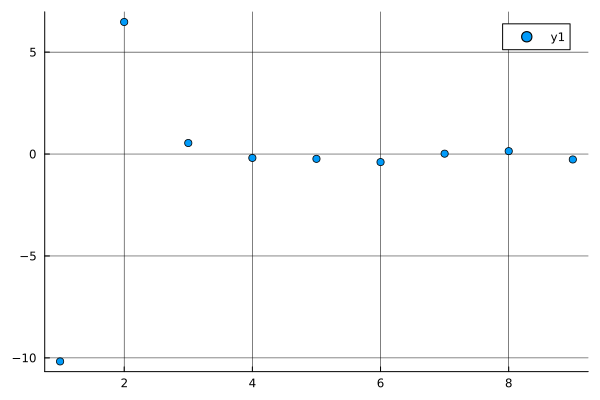

In [51]:
plot(delta_e, seriestype = [:scatter], grid = true, gridalpha = 2, gridcolor = :black)